# TRABALHO - ML

# Instalação de Dependencias


In [ ]:
!pip install ucimlrepo

# Importação de Bibliotecas


In [ ]:
# Para reprodutibilidade em Python
import os
os.environ['PYTHONHASHSEED'] = '0'

# Semente para o módulo random do Python
import random
random.seed(42)

# Semente para NumPy
import numpy as np
np.random.seed(42) # Semente para operações do TensorFlow


import tensorflow as tf
from ucimlrepo import fetch_ucirepo # Importa datasets do UCI ML Repository
from sklearn.model_selection import train_test_split# Divisão treino/teste
from sklearn.preprocessing import StandardScaler # Normalização dos dados
from sklearn.preprocessing import OneHotEncoder# Codificação dos rótulos
from sklearn.utils.class_weight import compute_class_weight # Cálculo de pesos das classes
from tensorflow import keras
from tensorflow.keras import regularizers # Regularização L2
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping para evitar overfitting
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt # Importa os Graficos


# Importação dos Dados

*Carregar dataset ID = 17*

In [ ]:
dataset = fetch_ucirepo(id=17)  # Carrega o dataset Breast Cancer Wisconsin (Diagnostic)

X = dataset.data.features.to_numpy()  # Converte as features para array NumPy
y = dataset.data.targets.to_numpy().ravel()  # Converte os rótulos para array 1D

## Divisão dos dados e Padronização

In [ ]:
# Divide os dados em conjuntos de treino (80%) e teste (20%) de forma estratificada para manter a proporção das classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

# Padronização das features
scaler = StandardScaler() # Cria uma instância do StandardScaler
X_train = scaler.fit_transform(X_train) # Ajusta o scaler nos dados de treino e os padroniza
X_test = scaler.transform(X_test) # Padroniza os dados de teste usando o scaler ajustado nos dados de treino


## One-Hot Encoding e Pesos das classes

In [ ]:
# One-hot encoding dos rótulos
encoder = OneHotEncoder(sparse_output=False) # Cria uma instância do OneHotEncoder, configurado para retornar um array denso
y_train_enc = encoder.fit_transform(y_train.reshape(-1,1)) # Ajusta o encoder nos rótulos de treino e aplica o one-hot encoding
y_test_enc = encoder.transform(y_test.reshape(-1,1)) # Aplica o one-hot encoding nos rótulos de teste usando o encoder ajustado

# Pesos de classe (balanceamento mesmo com classe quase equilibrada)
classes = np.unique(y_train) # Encontra as classes únicas nos rótulos de treino
# Calcula os pesos de classe para balancear as classes, usando a estratégia 'balanced'
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = dict(zip(range(len(classes)), weights)) # Cria um dicionário mapeando o índice da classe para o seu peso


**================================================================================**

# TESTE 1 (2 camadas: 5, 5, ReLU)


> Definição do Modelo MLP

In [ ]:
# Definir o modelo MLP otimizado
model = keras.Sequential([ # Inicia a definição de um modelo Sequential (sequência de camadas)
    keras.layers.Input(shape=(X_train.shape[1],)),  # Define a camada de entrada com o número de features dos dados de treino
    # Primeira camada oculta densa com 5 neurônios, ativação ReLU e regularização L2
    keras.layers.Dense(5, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.1), # Camada de Dropout com taxa de 10% para regularização
    keras.layers.Dense(5, activation='relu'), # Segunda camada oculta densa com 5 neurônios e ativação ReLU
    keras.layers.Dropout(0.1), # Segunda camada de Dropout com taxa de 10%
    # Camada de saída densa com o número de neurônios igual ao número de classes e ativação Softmax para classificação
    keras.layers.Dense(y_train_enc.shape[1], activation='softmax')
])


> Otimizador Adam/Binary Crossentropy e EarlyStopping

In [ ]:
# Compilar com otimizador Adam e binary_crossentropy (ou categorical_crossentropy)
model.compile( # Configura o modelo para treinamento
    optimizer='adam', # Define o otimizador Adam
    loss='categorical_crossentropy', # Define a função de perda como categorical_crossentropy (adequada para one-hot encoded labels)
    metrics=['accuracy'] # Define a métrica a ser monitorada durante o treinamento como acurácia
)

# EarlyStopping para evitar overfitting
es = EarlyStopping(monitor='val_accuracy', patience=150, restore_best_weights=True) # Cria um callback EarlyStopping // o treinamento só será interrompido se a val_accuracy não melhorar por 150 épocas consecutivas


> Treinamento do Modelo + Avaliação do Conjunto de Teste

In [ ]:
# Treinar o modelo com validação interna, pesos de classe e callbacks
history = model.fit( # Treina o modelo
    X_train, y_train_enc, # Dados de treino e rótulos one-hot encoded
    epochs=1000, # Número máximo de épocas para treinamento
    batch_size=32, # Tamanho do batch
    validation_split=0.2, # Define 20% dos dados de treino para validação
    class_weight=class_weight, # Aplica os pesos de classe calculados
    callbacks=[es], # Inclui o callback EarlyStopping
    verbose=0 # Mostra o progresso do treinamento
)

# Avaliar no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test_enc, verbose=0) # Avalia o modelo no conjunto de teste

# Prever no conjunto de teste para calcular outras métricas
y_pred_enc = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_enc, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Imprimir o relatório de classificação
print("\nRelatório completo (TESTE 1 - TESTE):")
print(classification_report(y_true, y_pred))

# Prever no conjunto de treino para calcular outras métricas
y_train_pred_enc = model.predict(X_train, verbose=0)
y_train_pred = np.argmax(y_train_pred_enc, axis=1)
y_train_true = np.argmax(y_train_enc, axis=1)

# Imprimir o relatório de classificação para o conjunto de treino
print("\nRelatório completo (TESTE 1 - TREINO):")
print(classification_report(y_train_true, y_train_pred))


Relatório completo (TESTE 1 - TESTE):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114


Relatório completo (TESTE 1 - TREINO):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       285
           1       0.99      0.91      0.94       170

    accuracy                           0.96       455
   macro avg       0.97      0.95      0.96       455
weighted avg       0.96      0.96      0.96       455



> Plot: Resultado Teste 1

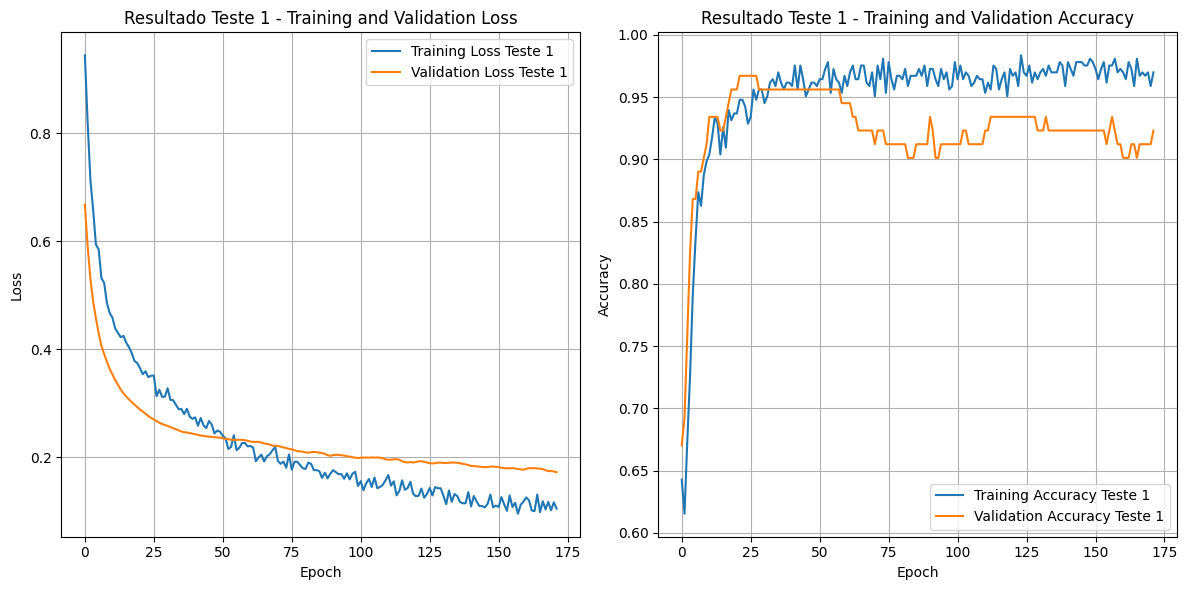

In [ ]:
# Plotar as curvas de loss e acurácia
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
plt.plot(history.history['loss'], label='Training Loss Teste 1')
plt.plot(history.history['val_loss'], label='Validation Loss Teste 1')
plt.title('Resultado Teste 1 - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
plt.plot(history.history['accuracy'], label='Training Accuracy Teste 1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy Teste 1')
plt.title('Resultado Teste 1 - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

**================================================================================**

# TESTE 2 (4 camadas: 4, 4, 4, 4, ReLU)

> Definição do Modelo MLP

In [ ]:
# MLP com 4 camadas ocultas (4 neurônios cada), ativação ReLU, dropout e regularização L2
model = keras.Sequential([ #
    keras.layers.Input(shape=(X_train.shape[1],)),
    # Primeira camada oculta
    keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(4, activation='relu'), # Segunda camada oculta
    keras.layers.Dropout(0.1),
    keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),    # Terceira camada oculta
    keras.layers.Dropout(0.1),
    keras.layers.Dense(4, activation='relu'), # Quarta Camada Oculta
    keras.layers.Dropout(0.1),
    keras.layers.Dense(y_train_enc.shape[1], activation='softmax')
])



> Otimizador Adam/Binary Crossentropy e EarlyStopping

In [ ]:
# Compilação padrão (sem EarlyStopping)
model.compile(
    optimizer='adam', # Otimizador Adam
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



> Treinamento do Modelo + Avaliação do Conjunto de Teste

In [ ]:
from sklearn.metrics import classification_report

# Treinamento sem callback, com menos épocas
history = model.fit(
    X_train, y_train_enc,
    epochs=300, # 300 épocas para treinamento
    batch_size=32,
    validation_split=0.2, # 20% dos dados de treino para validação
    class_weight=class_weight,
    verbose=0
)

# Avaliação do modelo
loss, accuracy = model.evaluate(X_test, y_test_enc, verbose=0)

# Previsões no teste
y_pred_enc = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_enc, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Impreção do relatorio
print("\nRelatório completo (TESTE 2 - TESTE):")
print(classification_report(y_true, y_pred))

# Previsões no treino
y_train_pred_enc = model.predict(X_train, verbose=0)
y_train_pred = np.argmax(y_train_pred_enc, axis=1)
y_train_true = np.argmax(y_train_enc, axis=1)

print("\nRelatório completo (TESTE 2 - TREINO):")
print(classification_report(y_train_true, y_train_pred))


Relatório completo (TESTE 2 - TESTE):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


Relatório completo (TESTE 2 - TREINO):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       285
           1       1.00      0.98      0.99       170

    accuracy                           0.99       455
   macro avg       0.99      0.99      0.99       455
weighted avg       0.99      0.99      0.99       455



> Plot: Resultado Teste 2

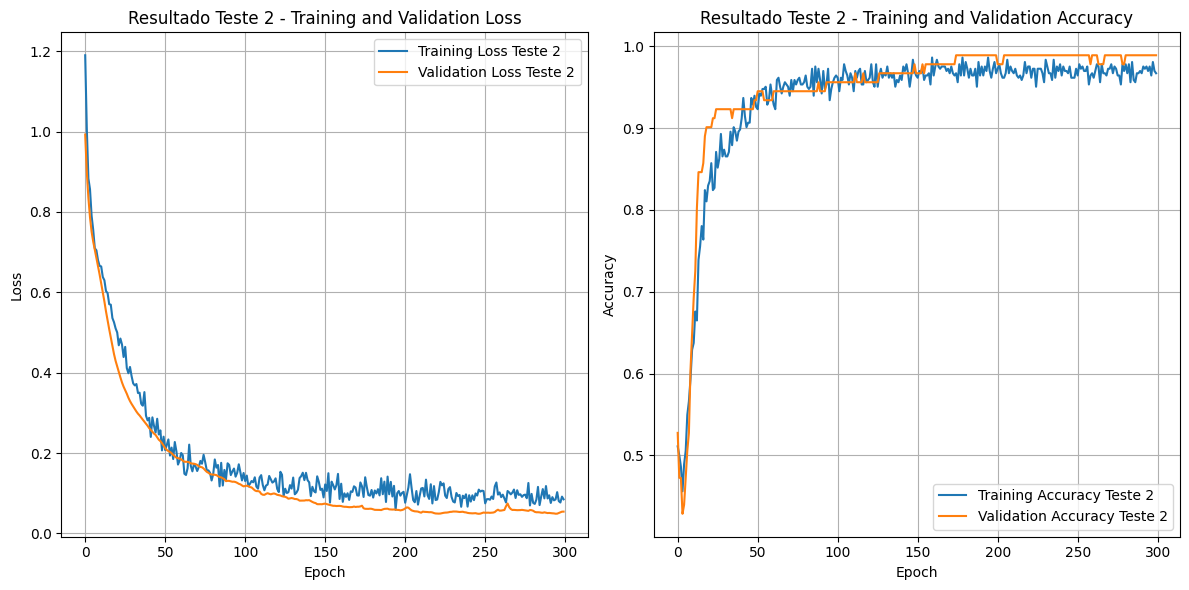

In [ ]:
# Plotar as curvas de loss e acurácia para o Teste 2
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
plt.plot(history.history['loss'], label='Training Loss Teste 2')
plt.plot(history.history['val_loss'], label='Validation Loss Teste 2')
plt.title('Resultado Teste 2 - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
plt.plot(history.history['accuracy'], label='Training Accuracy Teste 2')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy Teste 2')
plt.title('Resultado Teste 2 - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

**================================================================================**

# TESTE 3 (2 camadas: 5, 5, Tanh)

> Definição do Modelo MLP

In [ ]:
# MLP com 2 camadas ocultas (5 neurônios), ativação Tanh, dropout e regularização L2
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    # Primeira camada oculta densa com 5 neurônios e ativação Tanh
    keras.layers.Dense(5, activation='tanh', kernel_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(5, activation='tanh'), # Segunda  camada oculta densa com 5 neurônios e ativação Tanh
    keras.layers.Dropout(0.1),
    keras.layers.Dense(y_train_enc.shape[1], activation='softmax')
])


> Otimizador Adam/Binary Crossentropy e EarlyStopping

In [ ]:
model.compile(
    optimizer='adam', # Otimizador Adam
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping ativado (mesma configuração do Teste 1)
es = EarlyStopping(monitor='val_accuracy', patience=150, restore_best_weights=True)

> Treinamento do Modelo + Avaliação do Conjunto de Teste

In [ ]:
from sklearn.metrics import classification_report

history = model.fit(
    X_train, y_train_enc,
    epochs=1000, # 1000 épocas para treinamento
    batch_size=32,
    validation_split=0.2, # Define 20% dos dados de treino para validação
    class_weight=class_weight,
    callbacks=[es], # Inclui o callback EarlyStopping
    verbose=0
)

# Avaliação do conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test_enc, verbose=0)

y_pred_enc = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_enc, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Impreção do relatório de classificação
print("\nRelatório completo (TESTE 3 - TESTE):")
print(classification_report(y_true, y_pred))

y_train_pred_enc = model.predict(X_train, verbose=0)
y_train_pred = np.argmax(y_train_pred_enc, axis=1)
y_train_true = np.argmax(y_train_enc, axis=1)

# Impreção do relatório de classificação para o conjunto de treino
print("\nRelatório completo (TESTE 3 - TREINO):")
print(classification_report(y_train_true, y_train_pred))


Relatório completo (TESTE 3 - TESTE):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Relatório completo (TESTE 3 - TREINO):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.98      0.98      0.98       170

    accuracy                           0.98       455
   macro avg       0.98      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455



> Plot: Resultado Teste 3

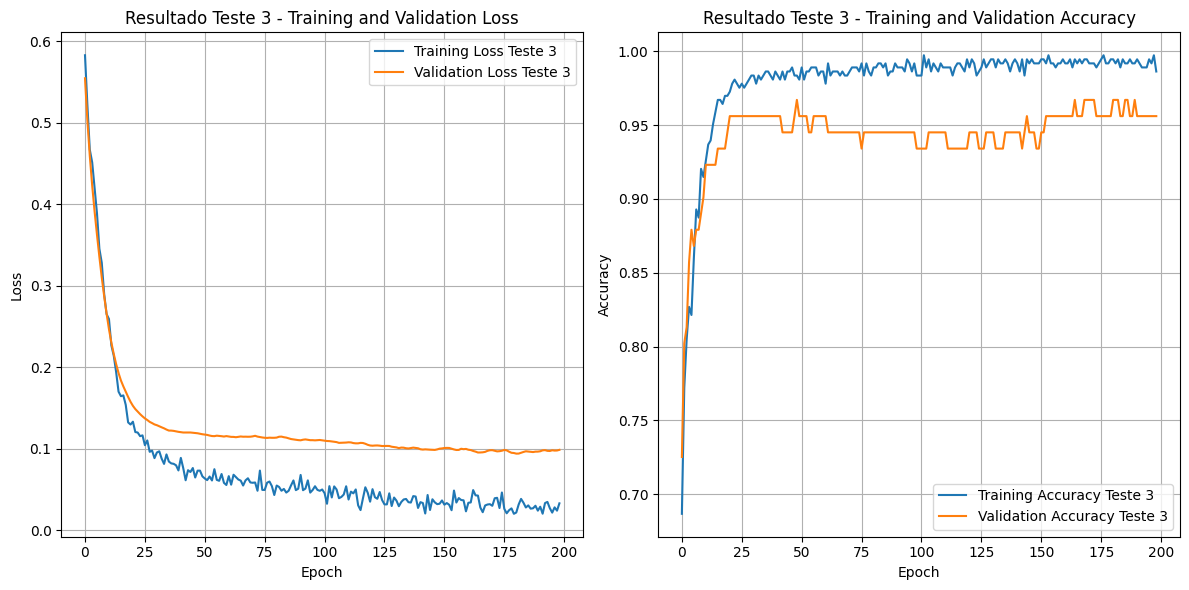

In [ ]:
# Gráficos de loss e acurácia do treinamento (Teste 3)
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
plt.plot(history.history['loss'], label='Training Loss Teste 3')
plt.plot(history.history['val_loss'], label='Validation Loss Teste 3')
plt.title('Resultado Teste 3 - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
plt.plot(history.history['accuracy'], label='Training Accuracy Teste 3')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy Teste 3')
plt.title('Resultado Teste 3 - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

**================================================================================**

# TESTE 4 (2 camadas: 5, 5, Sigmoid)

> Definição do Modelo MLP

In [ ]:
# MLP com 2 camadas ocultas (5 neurônios), ativação Sigmoid, dropout e regularização L2
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    # Primeira camada oculta densa com 5 neurônios, ativação Sigmoid,dropout e regularização L2
    keras.layers.Dense(5, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.1), #
    keras.layers.Dense(5, activation='sigmoid'), # Segunda camada oculta densa com 5 neurônios, ativação Sigmoid,dropout e regularização L2
    keras.layers.Dropout(0.1),
    keras.layers.Dense(y_train_enc.shape[1], activation='softmax')
])


> Otimizador Adam/Binary Crossentropy e EarlyStopping

In [ ]:
model.compile(
    optimizer='adam', # Otimizador Adam
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping ativado (mesma configuração dos Testes 1 e 3)
es = EarlyStopping(monitor='val_accuracy', patience=150, restore_best_weights=True)


> Treinamento do Modelo + Avaliação do Conjunto de teste

In [ ]:
from sklearn.metrics import classification_report

history = model.fit(
    X_train, y_train_enc,
    epochs=1000, # 1000 épocas para treinamento
    batch_size=32, # Tamanho do batch
    validation_split=0.2, # Define 20% dos dados de treino para validação
    class_weight=class_weight,
    callbacks=[es], # Inclui o callback EarlyStopping
    verbose=0
)

loss, accuracy = model.evaluate(X_test, y_test_enc, verbose=0)

# Prever no conjunto de teste para calcular outras métricas
y_pred_enc = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_enc, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Impreção o relatório de classificação
print("\nRelatório completo (TESTE 4 - TESTE):")
print(classification_report(y_true, y_pred))

# Prever no conjunto de treino para calcular outras métricas
y_train_pred_enc = model.predict(X_train, verbose=0)
y_train_pred = np.argmax(y_train_pred_enc, axis=1)
y_train_true = np.argmax(y_train_enc, axis=1)

# Impreção o relatório de classificação para o conjunto de treino
print("\nRelatório completo (TESTE 4 - TREINO):")
print(classification_report(y_train_true, y_train_pred))

> Plot: Resultado Teste 4

In [ ]:
# Gráficos de loss e acurácia do treinamento (Teste 4)
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
plt.plot(history.history['loss'], label='Training Loss Teste 4')
plt.plot(history.history['val_loss'], label='Validation Loss Teste 4')
plt.title('Resultado Teste 4 - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
plt.plot(history.history['accuracy'], label='Training Accuracy Teste 4')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy Teste 4')
plt.title('Resultado Teste 4 - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

**================================================================================**

# Conclusões e Análise dos Experimentos



Compare as métricas de desempenho (Acurácia, Precision, Recall, F1-score) nos conjuntos de treino e teste para cada configuração de rede neural (número de camadas, neurônios, funções de ativação).

Discuta a influência dos hiperparâmetros variados no desempenho do modelo. Observe as curvas de aprendizado (Loss e Accuracy) para identificar sinais de overfitting (gap grande entre treino e validação) ou underfitting (baixo desempenho em ambos).

Responda a perguntas como:
- Qual configuração apresentou o melhor desempenho no conjunto de teste?
- Como as diferentes funções de ativação impactaram o treinamento e a performance?
- Quais insights você obteve sobre a complexidade ideal do modelo para este dataset?

Utilize os relatórios de classificação e os gráficos gerados para fundamentar suas conclusões.